In [2]:
import lyricsgenius as genius
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import json
import requests
import time as t
import csv

In [360]:
access_token = 'PD7BJYimkApf5yaGUxA6WYNZuYmBSGs4YpT51WiXkf2qDK7MSHhqqJzCBBavYfOq'

In [361]:
def search_artist(artists, max_songs, access_token):
    '''
    This function uses the lyricsgenius libary (genius API) to extract 
    the fields: song title, artist, album, date and lyrics
    Stored in a pandas dataframe.
    parameters:
    artists = artist(s) or band(s) to search, passed as a list
    e.g. artists = ['Coldplay', 'Taylor Swift']
    max_songs = maximum number of songs to search for 
    Songs by artist are sorted by 'popularity'
    access_token = your access token of the genius API
    '''
    
    api = genius.Genius(access_token)
    
    # Initialise fields lists 
    list_lyrics = []
    list_title = []
    list_artist = []
    list_album = []
    list_date = []
    
    # Iterate over artists list
    for i in artists:
        artist = api.search_artist(i,
                                   max_songs=max_songs,
                                   sort='popularity')
        songs = artist.songs
        for song in songs:
            list_lyrics.append(song.lyrics)
            list_title.append(song.title)
            list_artist.append(song.artist)
            list_album.append(song.album)
            list_date.append(song.year)

    df = pd.DataFrame({'artist':list_artist,
                       'title':list_title,
                       'album':list_album,
                        'date':list_date,
                       'lyrics':list_lyrics})

    return df

In [362]:
def clean_lyrics(df, column):
    """
    This function cleans the words without importance and fix the format of the  dataframe's column lyrics 
    parameters:
    df = dataframe
    column = name of the column to clean
    """

    df[column] = df[column].str.lower()
    df[column] = df[column].str.replace(r"verse |[1|2|3]|chorus|bridge|outro","").str.replace("[","").str.replace("]","")
    df[column] = df[column].str.lower().str.replace(r"instrumental|intro|guitar|solo","")
    df[column] = df[column].str.replace("\n"," ").str.replace(r"[^\w\d'\s]+","")
    df[column] = df[column].str.strip()

    return df

In [363]:
def lyrics_metrics(df, column):
    '''
    Function to count lyrics word length, unique length 
    and unique index (number of unique lyrics divided by total lyrics)
    '''

    split = df[column].str.split()
    df[column + '_count'] = split.str.len()
    
    unique_lyrics_len = []
    
    for i in split:
        unique = np.unique(i)
        unique_length = len(unique)
        unique_lyrics_len.append(unique_length)

    df[column+'_unique_count'] = unique_lyrics_len

    unique_ratio = df[column+'_unique_count'] / df[column + '_count']
    df['unique_ratio'] = unique_ratio.round(3)
    
    return(df)

In [364]:
def get_lyrics(artist, title):
    '''
    Function that uses "https://lyrics.ovh/" API to fetch lyrics
    from a given artist and song title.
    This function cleans lyrics to remove unwanted characters.
    Returns one string containing the lyrics (not split)
    '''
    
    base_url = 'https://api.lyrics.ovh/v1/' + artist + '/' + title

    response = requests.get(base_url)
    status_code = response.status_code
    
    if status_code == 200:
        
        json_data = json.loads(response.content)
        lyrics = json_data['lyrics']
        # make all lyrics lower case
        lyrics = lyrics.lower()
        # Remove characters to isolate words
        unwanted_chars = ['\n', '\r', '(', ')', '[', ']', '.', '!', ",",
                          '"\"', '/',
                          'chorus', 'verse', 'intro', 'outro',
                          'instrumental', 'guitar', 'solo', 'drums']

        cleaned_lyrics = []
        
        for line in lyrics:
            if line in unwanted_chars:
                # Put a space instead of unwanted characters
                cleaned_lyrics.append(' ')

            else:
                cleaned_lyrics.append(line)

        lyrics = ''.join(cleaned_lyrics)

        # Final filter of unwanted whitespace
        lyrics = ' '.join(lyrics.split())

        return lyrics

    elif status_code != 200:
        print(f'Status code {status_code}')

        return ''

In [365]:
def relyric(df):
    '''
    Function that swaps out lyrics field in df 
    for lyrics found via get_lyrics function.
    Lyrics found via genius API are harder to clean
    e.g. they contain strings such as [verse1], or name
    the artist at the begining of a verse.
    '''

    new_lyrics = []
    for index, track in df.iterrows():
        better_lyrics = get_lyrics(str(track.artist), str(track.title))
        new_lyrics.append(better_lyrics)

    df.lyrics = new_lyrics
    return df

In [366]:
artists = ['Taylor Swift', 'Coldplay']
max_songs = 10
df = artist_df(artists, max_songs, access_token)

Searching for songs by Taylor Swift...

Song 1: "​cardigan"
Song 2: "​exile"
Song 3: "Lover"
Song 4: "​the 1"
Song 5: "Look What You Made Me Do"
Song 6: "​betty"
Song 7: "End Game"
Song 8: "ME!"
Song 9: "You Need To Calm Down"
Song 10: "​august"

Reached user-specified song limit (10).
Done. Found 10 songs.
Searching for songs by Coldplay...

Song 1: "The Scientist"
Song 2: "Viva la Vida"
Song 3: "Fix You"
Song 4: "Yellow"
Song 5: "Hymn for the Weekend"
Song 6: "A Sky Full of Stars"
Song 7: "Everglow"
Song 8: "Adventure of a Lifetime"
Song 9: "Orphans"
Song 10: "Paradise"

Reached user-specified song limit (10).
Done. Found 10 songs.


In [367]:
df = relyric(df)

In [368]:
df

,artist,title,album,date,lyrics
0,Taylor Swift,​cardigan,folklore,2020-07-24,vintage tee brand new phone high heels on cobb...
1,Taylor Swift,​exile,folklore,2020-07-24,i can see you standing honey with his arms aro...
2,Taylor Swift,Lover,Lover,2019-08-16,we could leave the christmas lights up 'til ja...
3,Taylor Swift,​the 1,folklore,2020-07-24,i'm doing good i'm on some new shit been sayin...
4,Taylor Swift,Look What You Made Me Do,reputation,2017-08-25,i don't like your little games don't like your...
5,Taylor Swift,​betty,folklore,2020-07-24,betty i won't make assumptions about why you s...
6,Taylor Swift,End Game,reputation,2017-11-10,i wanna be your end game i wanna be your first...
7,Taylor Swift,ME!,Lover,2019-04-26,i promise that you'll never find another like ...
8,Taylor Swift,You Need To Calm Down,Lover,2019-06-14,you are somebody that i don't know but you're ...
9,Taylor Swift,​august,folklore,2020-07-24,salt air and the rust on your door i never nee...


In [369]:
df = lyrics_metrics(df, 'lyrics')

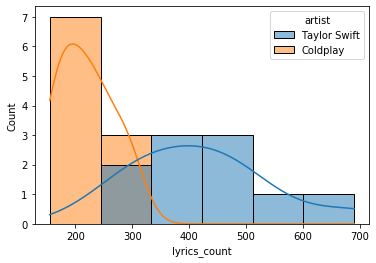

In [372]:
def lyrics_hist(df, column, category):
    '''
    function takes df column to plot histogram
    for a given category e.g. artist or albums
    '''
    
    sns.histplot(data=df,
                 x=column,
                 hue=category,
                 kde=True,
                 common_norm=False)
    
    plt.show()

lyrics_hist(df, df.lyrics_count, df.artist)

In [381]:
def make_wordcloud(lyrics, song_title, artist):
    '''
    Given song lyrics, produce a wordcloud 
    '''
    lyrics = lyrics.split()
    word_str = ' '.join(lyrics)

    wordcloud = WordCloud(width = 600,
                          height = 600,
                          background_color ='white',
                          stopwords = STOPWORDS,
                          min_font_size = 10,
                          collocations = False
                          ).generate(word_str)

    plt.figure(figsize = (6, 6), facecolor = None)
    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(f'{song_title} by {artist}')
    
    plt.show()

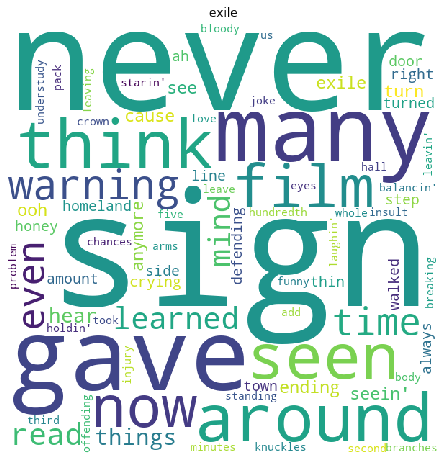

In [383]:
rand = df.sample()
artist = rand.artist.item()
song = rand.title.item()
lyrics = rand.lyrics.item()
make_wordcloud(lyrics,song)

In [3]:
artists = ['a','b']

In [14]:
def write_data(artists):
    current_time = int(t.time())
    with open('api_timing_record.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([current_time])
        writer.writerow(artists)

In [15]:
write_data(artists)

In [354]:
def read_data():
    read_list = []
    with open('api_timing_record.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            read_list.append(row)
    return read_list

In [355]:
read_data()

[['1606910337'], ['Taylor Swift', 'Coldplay']]

In [356]:
def check_api_calls(new_artists):
    read_list = read_data()
    time_elapsed = round(t.time()) - int(read_list[0][0])
    artists_called = read_list[1]
    time_until = 60 - time_elapsed
    if time_elapsed < 60 and any(artist in new_artists for artist in artists):
        print(f'''You are calling an artist previously called within the last 60 seconds.
You may not get all their lyrics due to the lyricsovh API restrictions.
Please wait {time_until}s to call the same artist again :)''')
        return False
    
    else:
        return True

In [357]:
new_artists = ['Taylor Swift', 'Metallica', 'Coldplay']

In [358]:
check_timing = check_api_calls(new_artists)

You are calling an artist previously called within the last 60 seconds.
You may not get all their lyrics due to the lyricsovh API restrictions.
Please wait 57s to call the same artist again :)


In [338]:
check_timing

True